# NRDT simplified (spectogram aiming to replace MFCC with reduced complexity)
# A transform with less than 20 code lines proved so far a convenient replacement of more sofisticated transforms (e.g.MFCCs) for various signal recognition problems.
# Particularly useful for HW-oriented devices (MCU, FPGAs) in the Tiny-ML context


Copyright Radu and Ioana DOGARU
Contact: radu.dogaru@upb.ro
Last update  Sept. 23, Oct. 23, 2025

For facile access to datasets run on Kaggle.

**Relevant papers (please cite)**

[1] R. Dogaru and I. Dogaru, "A low complexity solution for epilepsy detection using an improved version of the reaction-diffusion transform," 2017 5th International Symposium on Electrical and Electronics Engineering (ISEEE), Galati, Romania, 2017, pp. 1-6, doi: 10.1109/ISEEE.2017.8170678.
https://ieeexplore.ieee.org/document/8170678

[2] R. Dogaru and I. Dogaru, "State of the Art Recognition of Emotions from Speech, Using a Low Complexity Solution Based on Reaction-Diffusion Transform," 2022 International Symposium on Electronics and Telecommunications (ISETC), Timisoara, Romania, 2022, pp. 1-4, doi: 10.1109/ISETC56213.2022.10010234.
https://ieeexplore.ieee.org/document/10010234


# FixedPoint INT32 version with @JIT has around 100x speedup on CPU over MFCC in LIPBROSA
nrdt_2025z()

iRDT = improved RDT for usage in TinyML environments.

Copyright Radu and Ioana DOGARU

In [8]:
import numpy as np
import librosa
import time as ti
import matplotlib.pyplot as plt
from numba import jit
import math

@jit
# Note: if input signals are float - remove commented lines and type of signal argument
# This version works with int-type signal samples
# INT32 implementation
def nrdt_2025z(signal: np.int32, M=8, w=256, chan=[1,2,4,8, 16, 32, 64, 100]):
    # Copyright Radu DOGARU, radu.dogaru@upb.ro July 20, 2025
    #  assumes a float input signal in range -1,1 - internally it works with int32
    #-------------------------------------------------------------------------------
    #--- algorithm implementation int32
    m = len(chan)            # number of delays (a.k.a. filter banks )
    windows=len(signal)//w   # SHIFT when w is a power of 2
    Feat_spec = np.zeros((M,m)).astype('int32') #
    spectrum = np.zeros((windows,m)).astype('int32')
    lin=0
    limit=w//4   # a compromise between accuracy and comp. complexity (one may choose limit=w//2 or =0 for better accuracy

    for i in range(0,windows): # Compute the RDT "spectrum for each window "
        for k in range(0,m):
            delay=chan[k]
            spik=0
            for t in range(limit, w-limit):
                spik+=abs(signal[lin+t-delay]+signal[lin+t+delay]-2*signal[lin+t]) # // 2* as shift
            spectrum[i,k]= spik
        lin+=w
    # Averaging to get M segments
    # First and last rows are ignored to reject eroneous data computed out of signal buffers
    fer_per_segment=(windows -2) // M   # *** Generally if M is not a power of 2 - this is the only one division in various deployments (important in FPGA)
    lin=1  # start with 1 row (not with 0)
    for k in range(0,M):
        for col in range(0,m):
            spik=0
            for i in range(lin,lin+fer_per_segment):
                spik += spectrum[i,col]
            Feat_spec[k,col]= spik // (2*w)  # this can be done as shift *** 4 in caz de limit=0
        lin+=fer_per_segment
    #++++++++++++++++++++++++++++++++++++  next can be removed in HLS  (float conversion)
    return Feat_spec

# FLOAT32 implementation
@jit
def nrdt_2025zf(signal, M=8, w=256, chan=[1,2,4,8, 16, 32, 64, 100]):
    # Copyright Radu DOGARU, radu.dogaru@upb.ro July 20, 2025
    #  assumes a float input signal in range -1,1 - internally it works with int32
    #-------------------------------------------------------------------------------
    #--- algorithm implementation float32
    m = len(chan)            # number of delays (a.k.a. filter banks )
    windows=len(signal)//w   # SHIFT when w is a power of 2
    Feat_spec = np.zeros((M,m)).astype('float32') #
    spectrum = np.zeros((windows,m)).astype('float32')
    lin=0
    limit=w//4   # a compromise between accuracy and comp. complexity (one may choose limit=w//2 or =0 for better accuracy

    for i in range(0,windows): # Compute the RDT "spectrum for each window "
        for k in range(0,m):
            delay=chan[k]
            spik=0
            for t in range(limit, w-limit):
                spik+=abs(signal[lin+t-delay]+signal[lin+t+delay]-2*signal[lin+t]) # // 2* as shift
            spectrum[i,k]= spik
        lin+=w
    # Averaging to get M segments
    # First and last rows are ignored to reject eroneous data computed out of signal buffers
    fer_per_segment=(windows -2) // M   # *** Generally if M is not a power of 2 - this is the only one division in various deployments (important in FPGA)
    lin=1  # start with 1 row (not with 0)
    for k in range(0,M):
        for col in range(0,m):
            spik=0
            for i in range(lin,lin+fer_per_segment):
                spik += spectrum[i,col]
            Feat_spec[k,col]= spik // (2*w)  # this can be done as shift *** 4 in caz de limit=0
        lin+=fer_per_segment
    return Feat_spec


# Usage examples

[[  8  28  84 137  59  77]
 [  7  25  62  96  39  49]
 [  7  22  63 111  30  47]
 [  7  22  60 115  51  65]
 [  9  31  86 134  60  72]
 [  7  20  57  94  38  50]
 [  7  23  61 108  35  55]
 [  6  19  52  85  37  41]]


Text(0.5, 1.0, 'NRDT spectrogram')

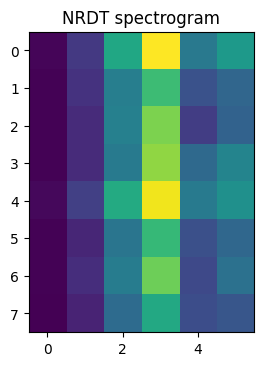

In [9]:
#ptt='/kaggle/input/bonn-eeg-dataset/Bonn Univeristy Dataset/O/O005.txt'
ptt = '/content/O005.txt'  # In Colab - data must be preloaded in working space
signal = np.loadtxt(ptt)
feat=nrdt_2025z(signal, M=8, w=128, chan=[1,2,4,8,16,32]) #chan=[32,36,40,48,56,128]) #=list(range(1,128,4))
print(feat)
plt.subplot(1,2,1); plt.imshow(feat);
plt.title('NRDT spectrogram')

# Comparison with MFCC with the same number of channells (mel-filters)

Ignore the first run

Duration of NRDT transform:  0.02959728240966797 seconds for  4097  samples
Duration of MFCC transform:  4.220365524291992 seconds for  4097  samples
[[115 137 126  84  28   8]
 [ 76  96  89  62  25   7]
 [ 94 111  98  63  22   7]
 [107 115  97  60  22   7]
 [110 134 128  86  31   9]
 [ 80  94  86  57  20   7]
 [100 108  92  61  23   7]
 [ 73  85  77  52  19   6]
 [ 88  98  91  63  24   7]]


Text(0.5, 1.0, 'MFCC spectrogram')

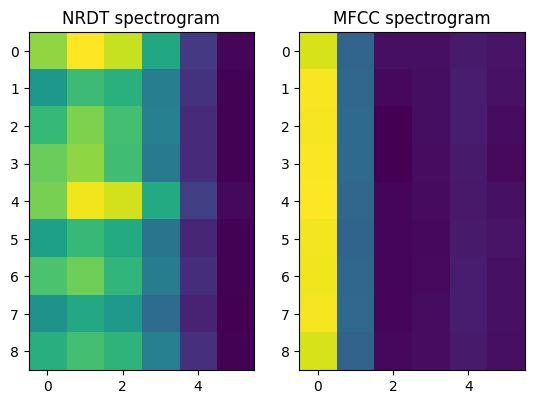

In [11]:
#ptt='/kaggle/input/bonn-eeg-dataset/Bonn Univeristy Dataset/O/O005.txt'
# Or download files from https://www.upf.edu/web/ntsa/downloads/-/asset_publisher/xvT6E4pczrBw/content/2001-indications-of-nonlinear-deterministic-and-finite-dimensional-structures-in-time-series-of-brain-electrical-activity-dependence-on-recording-regi
# in Colab you may upload locally
ptt = '/content/O005.txt'
signal = np.loadtxt(ptt)
#signal = (np.random.rand(2**18)-0.5).astype('float32')

# 1000 calls of iRDT
chan=[1,2,4,6,8,10]
t1=ti.time()
for k in range(1000):
  feat=nrdt_2025z(signal, M=9, w=128, chan=chan[::-1])   # .reverse to compare with MFCC - low frequenties on right side
t2=ti.time()
print('Duration of NRDT transform: ',t2-t1,'seconds for ',len(signal),' samples')

# 1000 calls of MFCC
t1=ti.time()
for k in range(1000):
  feat2 = librosa.feature.mfcc(y=signal, sr=10000, n_mfcc=6, n_fft=2048, hop_length=512).T
  #feat2 = librosa.feature.mfcc(y=signal, sr=10000, n_mfcc=6, n_fft=2048*64, hop_length=512*64).T
t2=ti.time()
print('Duration of MFCC transform: ',t2-t1,'seconds for ',len(signal),' samples')

feat.shape
print(feat)
plt.subplot(1,2,1); plt.imshow(feat); plt.title('NRDT spectrogram')
plt.subplot(1,2,2); plt.imshow(feat2); plt.title('MFCC spectrogram')